<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/09_lookup-table-with-faiss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

**이 노트북은 9장 '임베딩을 룩업 테이블로 사용하기' 절의 코드를 담고 있습니다.**

### 9.4.2 임베딩을 룩업 테이블로 사용하기

유용한 텍스트 표현 덕분에 GPT-3 같은 대규모 언어 모델은 제한된 데이터로 문제를 해결하는데 뛰어남
- 이런 표현은 감성, 토픽, 텍스트 구조 등의 많은 차원에 걸쳐 정보를 인코딩함
- 대규모 언어 모델의 임베딩을 사용해 의미 검색 엔진(semantic search engine)을 개발하고, 비슷한 문서나 코멘트를 찾고, 심지어 텍스트를 분류하는 작업도 가능


이 절에서는 OpenAI API 분류 엔드포인트를 본떠 텍스트 분류기를 생성함

1. 언어 모델을 사용해 레이블링된 전체 텍스트를 임베딩함

2. 저장된 임베딩에 최근접 이웃 검색을 수행함

3. 최근접 이웃의 레이블을 수집해 예측을 실시


아래 그림은 모델을 사용해 레이블링된 데이터를 임베딩해서 레이블과 함께 저장하는 방법을 보여줌
- 새로운 텍스트를 분류할 때 이를 임베딩한 후 최근접 이웃의 레이블을 기반으로 새로운 텍스트의 레이블을 부여함
- 탐색할 이웃의 개수를 조정하는 것이 중요함
- 너무 적으면 잡음이 많고 너무 많으면 이웃한 그룹이 혼합됨



<img alt="nearest-neighbours" caption="An illustration of nearest neighbor embedding lookup" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_nearest-neighbours.png?raw=1" id="nearest-neighbours"/>

**[그림 9-3]** 최근접 이웃 임베딩 룩업

- 이 방식은 레이블링된 데이터 포인트를 활용하기 위해 모델을 미세 튜닝할 필요가 없음

- 대신 현재 데이터셋과 비슷한 도메인에서 사전 훈련된 적절한 모델을 선택하는 것이 중요함

- GPT-3는 OpenAI API를 통해서만 사용 가능하므로 GPT-2를 사용해 이 기법을 테스트함
  + 구체적으로 파이썬 코드에서 훈련된 GPT-2 변종을 사용

텍스트 리스트를 받고 이 모델을 사용해 각 텍스트에 대해 하나의 벡터 표현을 만드는 헬퍼 함수를 작성(이때 한 가지 문제를 처리해야 함)
- GPT-2 같은 트랜스포머 모델은 토큰마다 하나의 임베딩 벡터를 반환함
- 예를 들어 'I took my dog for a walk' 문장이 주어지면 토큰마다 임베딩 벡터가 여러 개 나옴
- 하지만 실제로 필요한 것은 전체 문장(여기서는 깃허브 이슈)에 대한 임베딩 벡터 하나
- 이를 처리하기 위해 **풀링(pooling)**이라는 기법을 사용
- 가장 간단한 풀링 방법은 토큰 임베딩을 평균하는 **평균 풀링(mean pooling)**을 사용
  + 평균 풀링에서 주의할 점은 평균에 패딩 토큰을 포함하지 말아야 함
  + 어텐션 마스크를 사용해 이를 처리



In [1]:
# 최신 라이브러리를 설치합니다.
!pip install transformers datasets faiss-cpu scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00


In [2]:
# 필요한 패키지를 임포트합니다.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

데이터를 다운로드합니다.

In [3]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)

레이블 열을 레이블 이름의 리스트로 바꿉니다.



In [4]:
df_issues["labels"] = (df_issues["labels"]
                       .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


 레이블 열을 필터링합니다.

In [5]:
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

레이블 열을 확장합니다.

In [6]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


레이블링 여부를 기록한 `split` 열을 만듭니다.

In [7]:
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


제목과 본문을 합칩니다.

In [8]:
df_issues["text"] = (df_issues
                     .apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

중복 이슈를 삭제합니다.

In [9]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"삭제된 중복 이슈: {(len_before-len(df_issues))/len_before:.2%}")

삭제된 중복 이슈: 1.88%


훈련 세트를 만듭니다.

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])

MultiLabelBinarizer()

In [11]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels,
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

In [12]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [13]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

훈련 슬라이스를 만듭니다.

In [14]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # 다음 슬라이스 크기를 채우는데 필요한 샘플을 분할합니다
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# 마지막 슬라이스를 포함하면 코랩의 경우 메모리 부족이 발생합니다.
# 대신 코랩 프로(https://colab.research.google.com/signup)를 사용하세요.
# 코랩을 사용하려면 다음 라인을 주석 처리하세요.
train_slices.append(all_indices), train_samples.append(len(ds["train"]))

train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

`label_ids` 열을 만듭니다.

In [15]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

결과를 저장할 딕셔너리를 만듭니다.

In [16]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

그래프 출력 함수를 정의합니다.

In [17]:
def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run,
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

### 임베딩을 룩업 테이블로 사용하기

작동 방식을 이해하기 위해 GPT-2 토크나이저와 모델을 로드하고 평균 풀링 연산을 정의한 후, 전 과정을 embed_text() 함수로 wrapping 함

In [18]:
import torch
from transformers import AutoTokenizer, AutoModel

# 코랩에서 python-gpt2-large를 사용하면 메모리 부족이 발생합니다.
# 대신 코랩 프로(https://colab.research.google.com/signup)를 사용하세요.
# 코랩을 사용하려면 대신 python-gpt2-medium을 사용하세요.
model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
    # 토큰 임베딩 추출하기
    token_embeddings = model_output[0]
    # 어텐션 마스크 계산하기
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())
    # 임베딩을 더하지만 마스킹된 토큰은 무시합니다
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # 하나의 벡터로 평균을 반환합니다
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
                       max_length=128, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

이제 각 분할에 대한 임베딩을 얻을 수 있음

- GPT 스타일의 모델은 패딩 토큰이 없으므로 앞의 코드에서 구현된 것처럼 배치 형식으로 임베딩을 구하려면 패딩 토큰을 추가해야 함
- 이를 위해 EOS(End Of String) 토큰을 재사용

In [19]:
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

모든 임베딩이 준비되었으니 이를 검색할 시스템을 구성함

- 쿼리할 새로운 텍스트 임베딩과 훈련 세트에 있는 기존 임베딩 사이의 코사인 유사도(cosine similarity)를 계산하는 함수를 작성
- FAISS 인덱스라 부르는 허깅페이스 데이터셋의 내장 구조를 사용
- add_faiss_index()를 사용하여 데이터셋의 기존 필드를 FAISS 인덱스로 만듦
- 또 add_faiss_index_from_external_arrays()를 사용하면 새로운 임베딩을 데이터셋으로 로드함

**Note** FAISS를 사용하려면 faiss-cpu나 faiss-gpu 패키지를 설치해야 함

In [20]:
embs_train.add_faiss_index("embedding")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 223
})

embedding 이라는 새로운 FAISS 인덱스를 생성함. 이제 get_nearest_examples() 메서드를 호출해 최근접 이웃 룩업을 수행함
- 이 메서드는 가장 가까운 이웃과 각 이웃의 매칭 점수를 반환
- 이를 위해 쿼리 임베딩과 추출할 최근접 이웃 개수를 지정함

이 메서드를 한번 호출해서 주어진 샘플과 가장 가까운 문서를 확인

In [21]:
i, k = 0, 3     # 첫 번째 쿼리와 3개의 최근접 이웃을 선택합니다
rn, nl = "\r\n\r\n", "\n"   # 간결한 출력을 위해 텍스트에서 줄바꿈 문자를 삭제합니다

query =  np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)

print(f"쿼리 레이블: {embs_valid[i]['labels']}")
print(f"쿼리 텍스트:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"추출된 문서:")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
    print("="*50)
    print(f"텍스트:\n{text[:200].replace(rn, nl)} [...]")
    print(f"점수: {score:.2f}")
    print(f"레이블: {label}")

쿼리 레이블: ['new model']
쿼리 텍스트:
Implementing efficient self attention in T5

# 🌟 New model addition
My teammates and I (including @ice-americano) would like to use efficient self attention methods such as Linformer, Performer and [...]

추출된 문서:
텍스트:
Add Linformer model

# 🌟 New model addition
## Model description
### Linformer: Self-Attention with Linear Complexity
Paper published June 9th on ArXiv: https://arxiv.org/abs/2006.04768
La [...]
점수: 54.92
레이블: ['new model']
텍스트:
Add FAVOR+ / Performer attention

# 🌟 FAVOR+ / Performer attention addition
Are there any plans to add this new attention approximation block to Transformers library?
## Model description
The n [...]
점수: 57.90
레이블: ['new model']
텍스트:
Implement DeLighT: Very Deep and Light-weight Transformers

# 🌟 New model addition
## Model description
DeLight, that delivers similar or better performance than transformer-based models with sign [...]
점수: 60.12
레이블: ['new model']


임베딩 룩업으로 얻은 세 문서는 레이블이 모두 똑같음
- 제목을 보면 세 문서가 매우 비슷함

쿼리와 검색된 문서는 고효율의 신형 트랜스포머 모델을 추가하는 문제를 다움
- 최적의 k 값을 찾기 위해 헬퍼 함수를 만들어 몇 개의 k 값과 레이블 할당을 위한 임곗값 m < k로 바꿈

각 설정에서 매크로와 마이크로 F-1 점수를 기록해 나중에 가장 좋은 성능을 내는 설정을 정함

검증 세트에 있는 각 샘플에서 루프를 반복하지 않고 쿼리 배치를 받는 get_nearest_examples_batch() 메서드 사용

In [22]:
def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch("embedding",
                                                             valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred,
                target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

모든 k와 m 설정에서 전체 훈련 샘플을 사용해 최상의 값을 찾고 이 점수를 시각화함

In [23]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

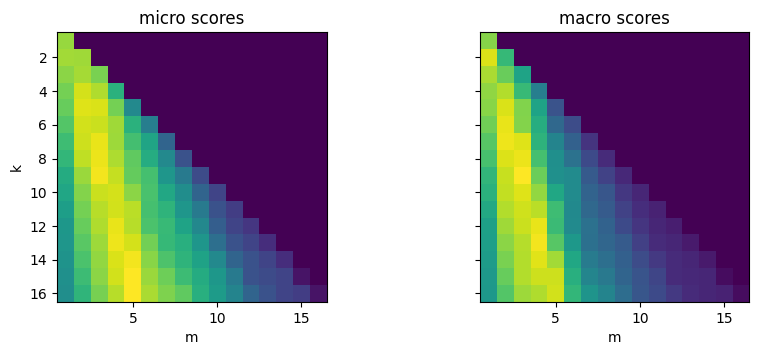

In [24]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")
plt.show()

그래프에서 패턴이 보임. 어떤 k에서 m이 너무 크거나 작으면 최적이 아닌 결과를 얻음

대략 m/k = 1/3의 비율로 선택할 때 성능이 가장 좋음

전반적으로 어떤 k와 mdl 최상의 결과를 내는지 확인

In [25]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"최상의 k: {k}, 최상의 m: {m}")

최상의 k: 15, 최상의 m: 5


도출된 결과와 같이 k=15와 m=15일 때 성능이 최상임

다른 말로 하면, 15개의 최근접 이웃을 검색하고 최소한 5회 등장한 레이블을 할당할 때 최상의 성능을 달성함

임베딩 룩업을 위해 최상의 값을 찾는 좋은 방법을 알았으니, 나이브 베이즈 분류기처럼 훈련 세트 슬라이스를 사용해 성능을 평가

- 데이터셋을 슬라이싱하기 전에 FAISS 인덱스는 데이터셋처럼 슬라이싱하지 못하므로 인덱스를 삭제
- 나머지 루프는 최상의 k와 m 값을 구하기 위해 검증 세트를 사용하는 것을 제외하면 이전과 같음

In [26]:
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # 훈련 슬라이스로부터 FAISS 인덱스를 만듭니다
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")
    # 검증 세트로 최상의 k, m 값을 구합니다
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
    # 테스트 세트에서 예측을 만듭니다
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])
    # 예측을 평가합니다
    clf_report = classification_report(test_labels, y_pred,
        target_names=mlb.classes_, zero_division=0, output_dict=True,)
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

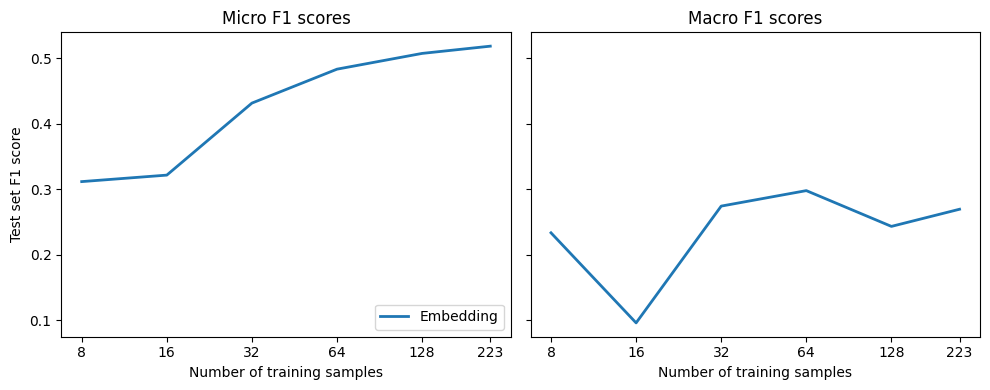

In [27]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

결과를 저장합니다.

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import joblib

joblib.dump({'micro': micro_scores, 'macro': macro_scores}, '/content/drive/MyDrive/trnsfmr/09_results_of_faiss.gz')

['/content/drive/MyDrive/trnsfmr/09_results_of_faiss.gz']